In [1]:
# Thoomas Goldman 2023
# DOLPHINN
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle 

#Get the absolute path of the current scriptf
current_path = os.path.dirname(os.path.abspath('__file__'))
dolphinn_path = os.path.join(current_path, '..')
sys.path.append(dolphinn_path)

from DOLPHINN.pinn import DOLPHINN 
from DOLPHINN.training import Scheduler, Restarter, Restorer
from DOLPHINN.metrics import FinalDr, FinalDv, FinalDm, Fuel, FuelTUDAT, FinalRadius
from DOLPHINN.callbacks import StoreAnimationData

from DOLPHINN import plotting
from DOLPHINN import utils


Using backend: tensorflow
Other supported backends: tensorflow.compat.v1, pytorch, jax, paddle.
paddle supports more examples now and is recommended.


In [2]:
mu = 1.32712440042e20 # SUN
m = 100 #Spacecraft mass
AU = 1.5e11 #EARTH-SUN
a = 10
umax = 0.1
isp = 2500

rp = AU
ra = 1.5*AU

e = (ra - rp)/(ra + rp)
sma = (rp + ra)/2

# Initial state
r0 = AU
vr0 = 0
vt0 = np.sqrt(mu/r0)
initial_state = np.array([r0, vr0, vt0])

# Final state
rfinal = 1.5*AU
vr_final = 0
vt_final = np.sqrt(mu/rfinal)
final_state = np.array([rfinal, vr_final, vt_final])

# Non dimensionalize
length_scale = AU
time_scale = AU / vt0

initial_state[:1] = initial_state[:1]/length_scale
initial_state[1:] = initial_state[1:]*time_scale/length_scale

final_state[:1] = final_state[:1]/length_scale
final_state[1:] = final_state[1:]*time_scale/length_scale

# Integration times
period = 2*np.pi*np.sqrt(sma**3/mu)
t0 = 0
tfinal = 1*period
N = 200

# Network architecture
input_dimension = 1
output_dimension = 6
neurons = 5
hidden_layers = 3

layer_size = [input_dimension] + [[neurons]*output_dimension] * hidden_layers + [output_dimension] # Parralel networks
layer_size = [input_dimension] + [20]*4 + [output_dimension] # 

data = {"initial_state": initial_state,
        "final_state": final_state,
        "mu": mu,
        "m": m,
        "a": a,
        "umax": umax,
        "isp": isp,
        "length_scale": length_scale,
        "time_scale": time_scale,
        "t0": t0,
        "tfinal": tfinal/time_scale,
        "architecture": layer_size,
        "activation": "sin",
        "N_train": N,
        "N_boundary": 2,
        "N_test": N,
        "sampler": "perturbed_uniform_tf"}

In [32]:
base_folder = "../data/Optimisation/LVLHm_fuel/mars_1_revolv_weights_grid2/"
weigths = np.geomspace(1e-9, 1e-5, 5)

for i, weigth in enumerate(weigths):
    
    for j in range(5): 
        print(f"[DOLPHINN] Weight: {weigth} ({i}/{len(weigths)}) ({j}/5)")

        problem = DOLPHINN(data,
                            "TwoBodyProblemRadialNonDimensionalControl_mass",
                            output_transform = "InitialFinalStateLayer_Radial_tanh_mass",
                            objective = "OptimalFuel", 
                            metrics = [FinalDr, FinalDv, FinalDm, Fuel], 
                            verbose = False)

        restarter = Restarter([(1e-2, 3000)], loss_weigths = [1, 1, 1, 1e-5, weigth])
        schedule = Scheduler([(1e-3, 5000), (1e-4, 10000), (5e-3, 4000), (1e-4, 5000), (5e-3, 4000), (1e-4, 5000)],
                             loss_weigths= [1, 1, 1, 1e-5, weigth]
                            )

        problem.train([restarter, schedule])
        problem.store(base_folder + f"weight_{i}_#{j}/")

[DOLPHINN] Weight: 1e-09 (0/5) (0/5)
'compile' took 0.001317 s

Training model...

'train' took 10.323134 s

'compile' took 0.065042 s

Training model...

'train' took 12.221396 s

'compile' took 0.053658 s

Training model...

'train' took 19.032350 s

'compile' took 0.052971 s

Training model...

'train' took 10.035334 s

'compile' took 0.056459 s

Training model...

'train' took 11.591245 s

'compile' took 0.054785 s

Training model...

'train' took 10.797713 s

'compile' took 0.052820 s

Training model...

'train' took 11.866740 s

Saving loss history to ../data/Optimisation/LVLHm_fuel/mars_1_revolv_weights_grid2/weight_0_#0/loss.dat ...
Saving training data to ../data/Optimisation/LVLHm_fuel/mars_1_revolv_weights_grid2/weight_0_#0/train.dat ...
Saving test data to ../data/Optimisation/LVLHm_fuel/mars_1_revolv_weights_grid2/weight_0_#0/test.dat ...
[DOLPHINN] Saving config file to ../data/Optimisation/LVLHm_fuel/mars_1_revolv_weights_grid2/weight_0_#0/config
[DOLPHINN] Weight: 1e-09

In [3]:
base_folder = "../data/Optimisation/LVLHm_final_mass/mars_1_revolv_weights_grid/"
weigths = np.geomspace(1e-7, 1e2, 10)

for i, weigth in enumerate(weigths):
    
    for j in range(3): 
        print(f"[DOLPHINN] Weight: {weigth} ({i}/{len(weigths)})")

        problem = DOLPHINN(data,
                            "TwoBodyProblemRadialNonDimensionalControl_mass",
                            output_transform = "InitialFinalStateLayer_Radial_tanh_mass",
                            objective = "OptimalFinalMass", 
                            metrics = [FinalDr, FinalDv, FinalDm, Fuel], 
                            display_every = 1000,
                            verbose = False)

        restarter = Restarter([(1e-2, 3000)], loss_weigths = [1, 1, 1, 1e-5, weigth])
        schedule = Scheduler([(1e-3, 5000), (1e-4, 10000), (5e-3, 4000), (1e-4, 5000), (5e-3, 4000), (1e-4, 5000)],
                             loss_weigths= [1, 1, 1, 1e-5, weigth])

        problem.train([restarter, schedule])
        problem.store(base_folder + f"weight_{i}_#{j}/")

[DOLPHINN] Weight: 1e-07 (0/10)
'compile' took 0.002527 s

Training model...

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
'train' took 19.158524 s

'compile' took 0.001449 s

Training model...

'train' took 18.140015 s

'compile' took 0.001241 s

Training model...

[DOLPHINN] Error occured in metric: `y` must contain only finite values.
[DOLPHINN] Error occured in metric: `y` must contain only finite values.
[DOLPHINN] Error occured in metric: `y` must contain only finite values.
'train' took 12.130722 s

'compile' took 0.001238 s

Training model...

'train' took 16.535128 s

'compile' took 0.001791 s

Training model...

'train' took 19.102732 s

'compile' took 0.001229 s

Training model...

'train' took 17.631893 s

'compile' took 0.001521 s

Training model...

[DOLPHINN] Error occured in metric: `y` must contain only finite value

In [20]:
animation = StoreAnimationData("../Data/Optimisation/LVLHm_fuel/case10/")

problem = DOLPHINN(data,
                    "TwoBodyProblemRadialNonDimensionalControl_mass",
                    output_transform = "InitialFinalStateLayer_Radial_tanh_mass",
                    objective = "OptimalFuel", 
                    metrics = [FinalDr, FinalDv, FinalDm, Fuel], 
                   callbacks = [animation])
mweigth = 1e-5
oweigth = 1e-5

restarter = Restarter([(1e-2, 3000)], loss_weigths = [1, 1, 1, mweigth, oweigth])
schedule1 = Scheduler([[1e-3, 5000], [1e-4, 10000], [5e-3, 4000], [1e-4, 5000]],
                      loss_weigths= [1, 1, 1, mweigth, oweigth])


problem.train([restarter, schedule1])

[DOLPHINN] Using time-dependent random seed: 20230713184006

[DOLPHINN] Training with procedure: Restarter

[RESTARTER] Initialisation attempt: 1
Compiling model...
'compile' took 0.001503 s

Training model...

Step      Train loss                                            Test loss                                             Test metric                                 
0         [5.08e+00, 9.68e+05, 3.33e+00, 3.22e-02, 1.28e-03]    [3.31e+00, 1.03e+06, 2.21e+00, 2.19e-02, 1.28e-03]    [3.26e+00, 3.50e+00, 7.21e+01, 1.28e+02]    
1000      [2.78e+01, 4.63e+00, 2.75e-01, 9.21e-02, 1.80e-03]    [1.84e+01, 5.13e+01, 2.92e-01, 6.34e-02, 1.80e-03]    [3.08e+02, 9.39e+01, 7.10e+01, 1.80e+02]    
2000      [2.45e+01, 2.59e+00, 1.01e-01, 3.08e-02, 1.80e-03]    [1.63e+01, 2.67e+00, 9.96e-02, 2.50e-02, 1.80e-03]    [9.06e+00, 2.28e+00, 7.50e+01, 1.80e+02]    
3000      [2.07e+01, 2.57e+00, 6.59e-02, 1.71e-02, 1.80e-03]    [1.39e+01, 1.25e+00, 5.17e-02, 1.68e-02, 1.80e-03]    [1.56e+01, 3.26e+00

In [44]:
schedule = Scheduler([(5e-3, 4000), (1e-4, 5000)],
                     loss_weigths= [1, 1, 1, mweigth, oweigth])
problem.train([schedule])


[DOLPHINN] Training with procedure: Scheduler

Compiling model...
'compile' took 0.112274 s

Training model...

Step      Train loss                                            Test loss                                             Test metric                                 
16000     [1.77e-06, 1.07e-06, 2.41e-06, 5.03e-07, 7.05e-04]    [1.77e-06, 1.07e-06, 2.40e-06, 4.95e-07, 7.05e-04]    [2.07e-02, 1.12e-02, -6.43e-01, 1.42e+00]   
17000     [3.35e-05, 5.18e-05, 6.57e-05, 4.63e-07, 7.02e-04]    [2.88e-05, 5.23e-05, 5.28e-05, 4.55e-07, 7.02e-04]    [2.64e-02, 1.33e-02, -6.20e-01, 1.42e+00]   
18000     [1.82e-06, 9.95e-07, 2.58e-06, 5.13e-07, 7.04e-04]    [1.82e-06, 9.97e-07, 2.56e-06, 5.06e-07, 7.04e-04]    [2.08e-02, 1.12e-02, -6.55e-01, 1.42e+00]   
19000     [3.05e-06, 1.13e-06, 3.20e-06, 5.62e-07, 7.04e-04]    [3.06e-06, 1.05e-06, 3.19e-06, 5.55e-07, 7.04e-04]    [2.09e-02, 1.08e-02, -6.92e-01, 1.42e+00]   
20000     [7.10e-06, 1.08e-05, 8.11e-06, 6.62e-07, 7.03e-04]    [7.11e-0

In [21]:
problem.print_config()


 ==================== Config Content ====================

----------Functions----------
dynamics                       TwoBodyProblemRadialNonDimensionalControl_mass
input_transform                NoneType
output_transform               InitialFinalStateLayer_Radial_tanh_mass
objective                      OptimalFuel

----------Problem----------
initial_state                  [1.0, 0.0, 1.0]
final_state                    [1.5, 0.0, 0.816496580927726]
mu                             1.32712440042e+20
m                              100
a                              10
umax                           0.1
isp                            2500
length_scale                   150000000000.0
time_scale                     5042908.305393074
t0                             0
tfinal                         8.781018413800906

----------Network----------
architecture                   [1, 20, 20, 20, 20, 6]
activation                     sin
sampler                        perturbed_uniform_tf
N_tra

[DOLPHINN] Setting up the TUDAT simulation
[DOLPHINN] Guidance is internal!
[DOLPHINN] Start Integrating
[DOLPHINN] Finished integrating in 0.0655 s


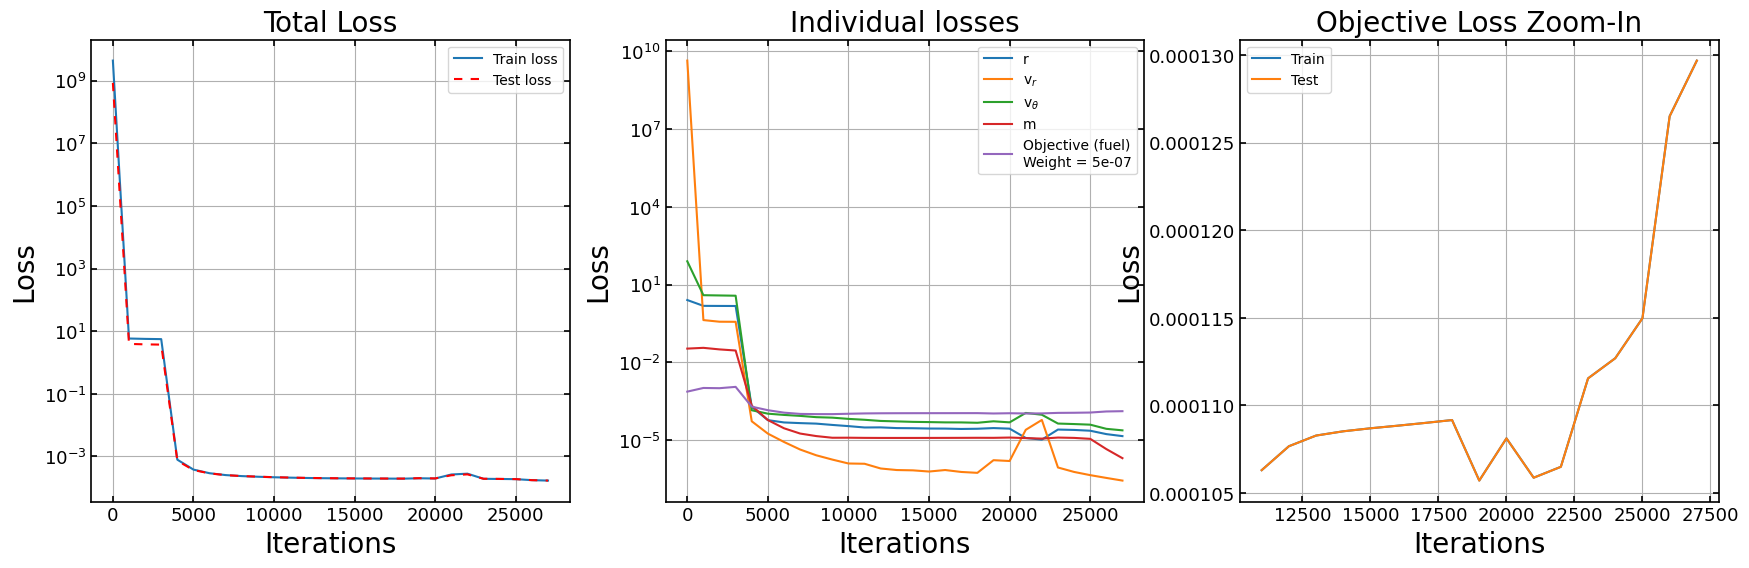

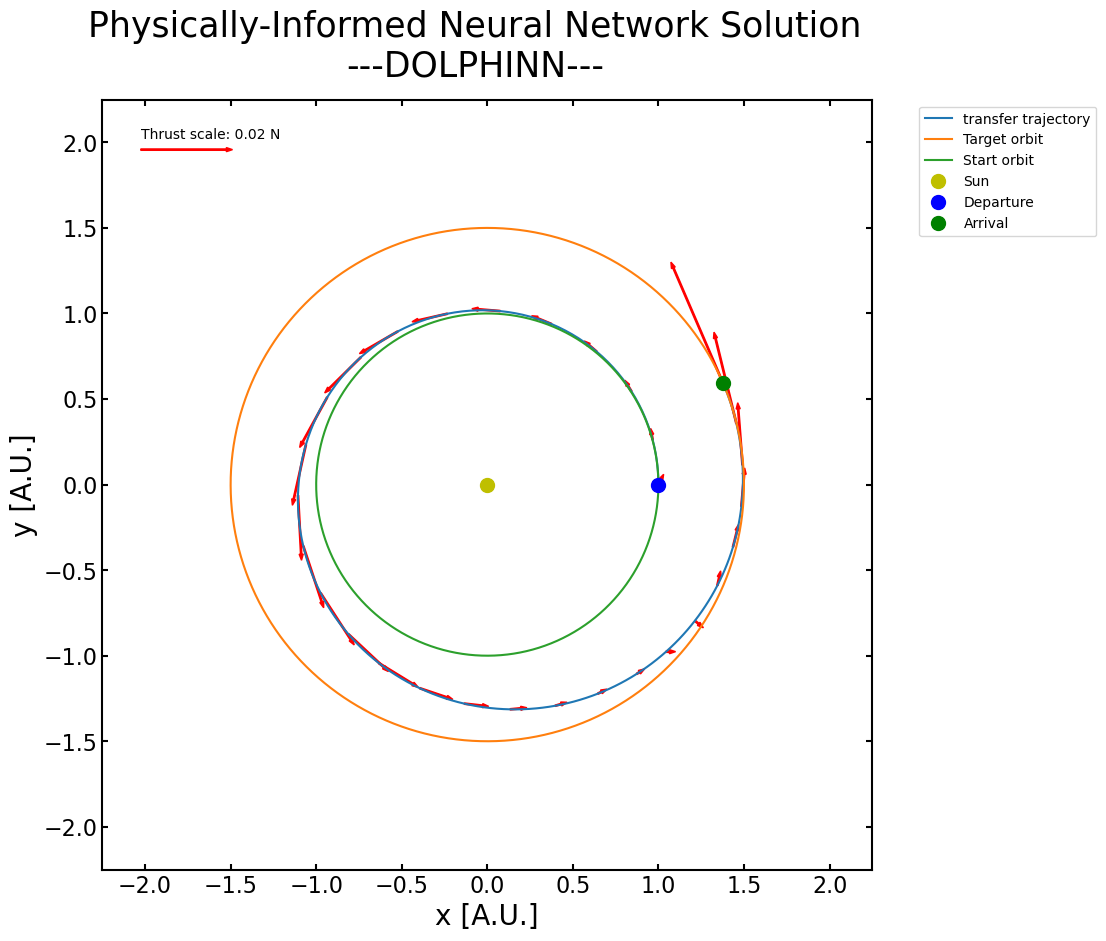

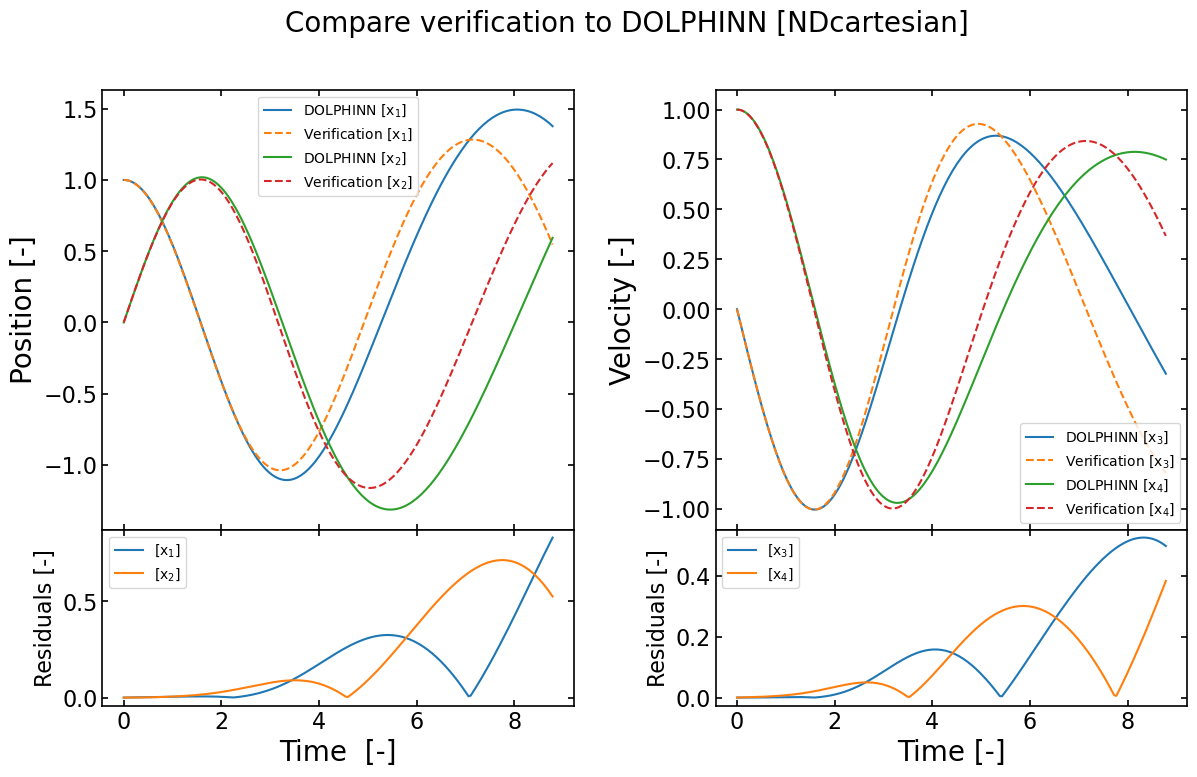

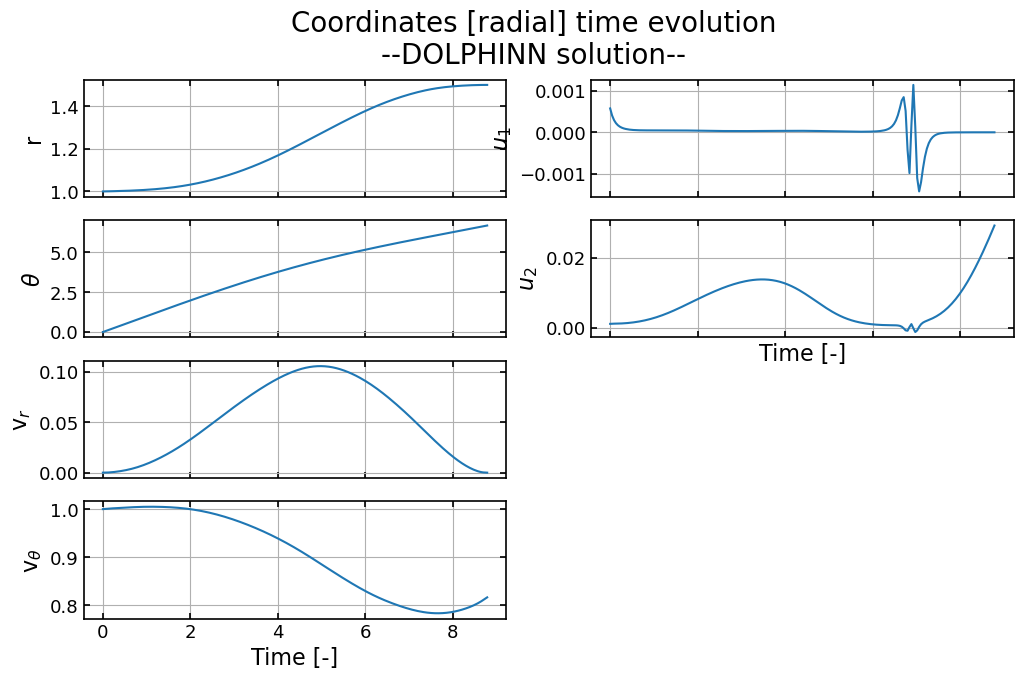

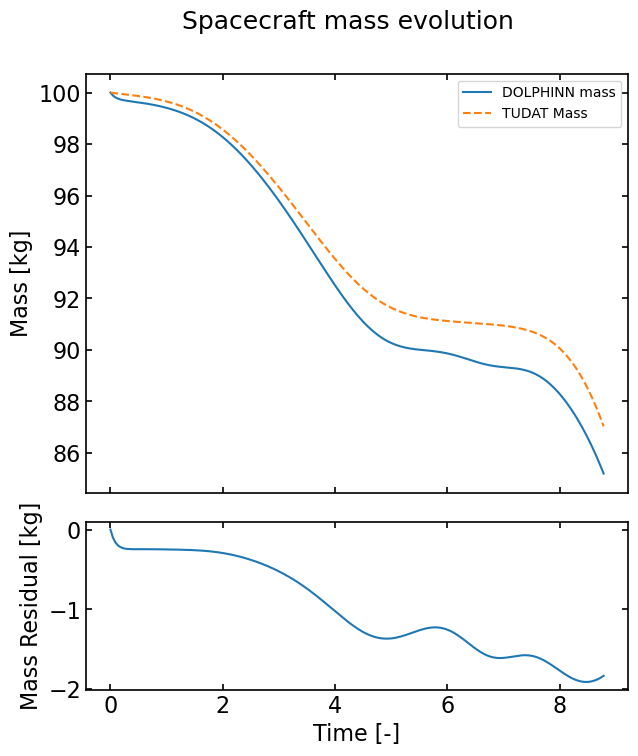

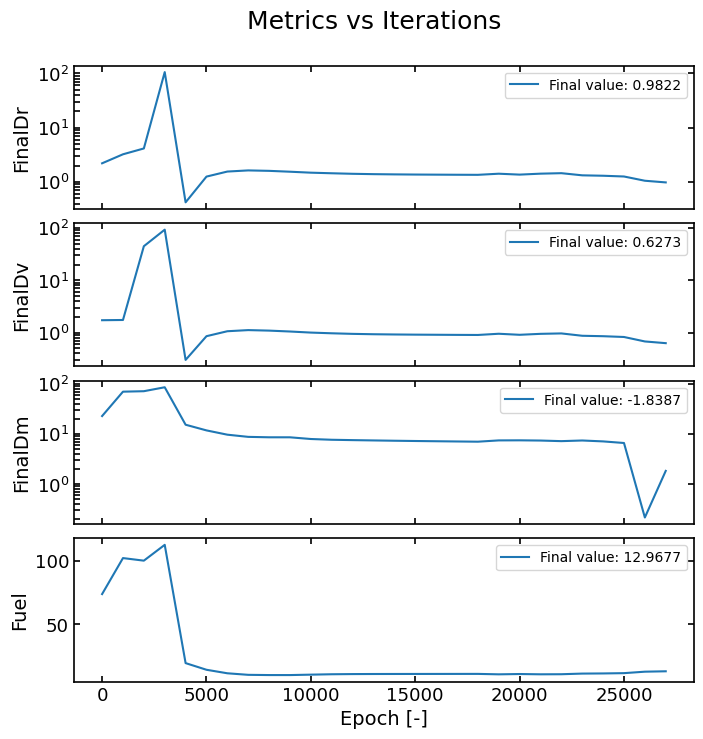

In [22]:
problem.verify()
plotting.plot_loss(problem, objective_zoom=True)  
plotting.plot_transfer(problem, bench = False, thrust_scale = 0.02, r_target = problem.states['radial'][-1, 1], N_arrows = 30)
plotting.compare(problem, 'NDcartesian', log = False)
plotting.plot_coordinates(problem, "radial")
plotting.compare_mass(problem)
plotting.plot_metrics(problem)


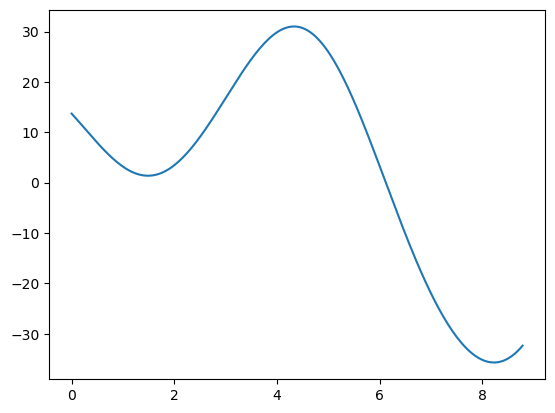

In [19]:
plt.plot(problem.states['NDcartesian'][:,0], np.rad2deg(np.arctan(problem.states['radial'][:,5]/problem.states['radial'][:,6])))

In [23]:
problem.store("../Data/Optimisation/LVLHm_fuel/case10/", overwrite = True)

Saving loss history to ../Data/Optimisation/LVLHm_fuel/case10/loss.dat ...
Saving training data to ../Data/Optimisation/LVLHm_fuel/case10/train.dat ...
Saving test data to ../Data/Optimisation/LVLHm_fuel/case10/test.dat ...
[DOLPHINN] Saving config file to ../Data/Optimisation/LVLHm_fuel/case10/config
